In [ ]:
# !pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

# Juego de la Vida (Game of Life)
El **Juego de la Vida**, también conocido como **Vida**, es un autómata celular diseñador por el matemático británico John Horton Conway en 1970. Es un juego sin jugadores, esto significa que su evolución está determinada por su estado inicial, sin requerir más entradas. Uno interactúa con el Juego de la Vida al crear un estado inicial (o configuración inicial) y se observa como evoluciona. Es Turing completo (puede simular cualquier máquina de Turing) y puede simular un constructor universal o cualquier otra máquina de Turing.
<center>
<img src="https://1.bp.blogspot.com/-pdQ2ckeQzCw/WwGFbYTKRoI/AAAAAAAAAY8/kb-gcutnkKc2TnQainAlYK5FlWmv87XywCPcBGAYYCw/s1600/ezgif.com-video-to-gif.gif" width=250 height=250 />
</center>

## Reglas

El universo (o entorno) del Juego de la Vida es infinito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de dos posibles estados, vivo o muerto (o poblado o despoblado, respectivamente). Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier celda viva con menos de dos vecinos vivos muere, debido a la poca población.
2. Cualquier celda viva con dos o tres vecinos vivos sobrevive para la siguiente generación.
3. Cualquier celda con más de tres vecinos vivos muere, debido a sobre población.
4. Cualquier celda muerta con exactamente tres vecinos vivos se convierte en una celda viva, debido a la reproducción.

Estas reglas, que comparan el comportamiento del autómata a la vida real, pueden ser condensadas en lo siguiente:

1. Cualquier celda viva con dos o más vecinos vivos sobrevive.
2. Cualquier celda muerta con tres vecinos vivos se convierte en una celda viva.
3. Cualquier otra celda viva muere en la siguiente generación. De manera similar, cualquier otra celda muerta se queda muerta.

El patrón inicial constituye la semilla del sistema. La primera generación es creada al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla, viva o muerta; nacimientos y muertes ocurren simultáneamente, y el momento discreto en el cual esto pasa es a veces llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [ ]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent)
# y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos
# ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen
# ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso
# de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos
# del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores
# numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de
# ejecución de nuestro algoritmo.
import time
import datetime

In [ ]:
class GameOfLifeAgent(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.live = np.random.choice([0, 1])
        self.next_state = None

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos,
                                                  moore = True,
                                                  include_center = False)

        count = 0
        for neighbor in neighbors:
            count += neighbor.live

        self.next_state = self.live
        if self.next_state == 1:
            if count < 2 or count > 3:
                self.next_state = 0
        else:
            if count == 3:
                self.next_state = 1

    def advance(self):
        self.live = self.next_state

In [ ]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (agent, (x, y)) in model.grid.coord_iter():
        grid[x][y] = agent.live
    return grid

In [ ]:
class GameOfLifeModel(Model):
    def __init__(self, width, height):
        super().__init__()
        self.grid = SingleGrid(width, height, torus = True)
        self.schedule = SimultaneousActivation(self)

        for (content, (x, y)) in self.grid.coord_iter():
            agent = GameOfLifeAgent(self)
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

        self.datacollector = DataCollector(model_reporters={
            "Grid" : get_grid} )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [ ]:
GRID_SIZE = 50
MAX_GENERATIONS = 200

model = GameOfLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(MAX_GENERATIONS):
    model.step()

/tmp/ipykernel_5883/557825039.py:5: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)


In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

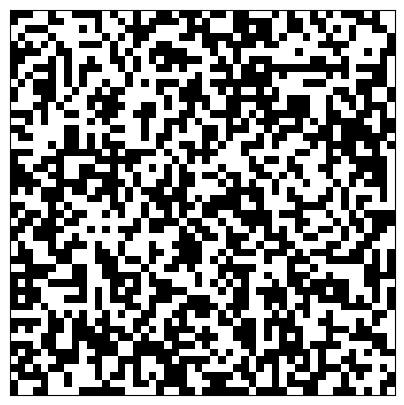

In [ ]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0,0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grids.iloc[i,0])

anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [ ]:
anim